In [1]:
import tensorflow as tf
import os
import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/Toan/MRI_ACDCA'


/content/drive/My Drive/Toan/MRI_ACDCA


In [4]:
train_path = '/content/drive/My Drive/Toan/MRI_ACDCA/training'
regions = {'enpi': 2.0 , 'endo': 3.0 , 'rv' : 1.0 }
test_size = 0.2
target_size = (192,192)
crop_size = (192,192)

In [12]:
def center_crop(img, crop_size = (100,100)):
  w_in, h_in = img.shape
  w_out, h_out = crop_size
  img_clone = np.zeros((w_out, h_out))
  sub_w = int((w_in - w_out)/2)
  sub_h = int((h_in - h_out)/2)
  img_clone = img[sub_w:sub_w+w_out, sub_h:sub_h+h_out]
  return img_clone


  

In [5]:
def get_data(list_file,is_crop = None ,target_size=(128,128), region = regions):
  
  x_train_list = []
  y_train_list = []

  x_train_list_o = []
  y_train_list_o = []
  

  for f in list_file:
    list_fimg = glob.glob(f+'/*')
    list_image = [aa for aa in list_fimg if aa.find('frame') != -1 and aa.find('gt') == -1]

    for im in list_image:
      num = im.find('nii')
      im_gt = im[:num-1] + '_gt.' +im[num:]
      image = nib.load(im)
      label = nib.load(im_gt)
      image = image.get_data().astype(np.uint8)
      label = label.get_data()

      for z in range(image.shape[-1]):
        sub_image = image[...,z]
        sub_label = label[...,z]
        sub_label =np.where(sub_label >= region['endo'], 1.0, 0.0).astype(np.float32) + np.where(sub_label >= region['enpi'], 1.0, 0.0).astype(np.float32)
        x_train_list_o.append(sub_image.shape)
        y_train_list_o.append(sub_label.shape)
        

        if is_crop:
          sub_label = center_crop(sub_label, crop_size=target_size)
          sub_image = center_crop(image[...,z], crop_size = target_size)

          
          

        else:
          sub_image  = PIL.Image.fromarray(sub_image)
          sub_label  = PIL.Image.fromarray(sub_label)
          sub_image = np.array(sub_image.resize(size=(target_size[0],target_size[1]),resample = PIL.Image.LANCZOS))
          sub_label = np.array(sub_label.resize(size=(target_size[0],target_size[1]),resample = PIL.Image.LANCZOS))

        y_train_list.append(sub_label)
        x_train_list.append(sub_image)
        
        
  x_ = np.asarray(x_train_list)
  y_ = np.asarray(y_train_list)
  #x_o = np.asarray(x_train_list_o)
  #y_o = np.asarray(y_train_list_o)
  
  return np.expand_dims(x_, axis = -1), np.expand_dims(y_, axis = -1)





In [ ]:
def padding_zero(image):
  h ,w = image.shape

  a = min(h,w)
  b = max(h,w)
  pad = (b-a)//2

  img = np.zeros(shape=(b,b))
  if h > w:
    img[:,pad:w+pad] = image
  elif h<w:
    img[pad:h+pad,:] =image
  else:
    img[pad:w+pad,pad:w+pad] = image

  return img



In [7]:
def get_list_file(path=train_path,rate = 0.3,seed = 42):
  list_file = glob.glob(path+'/*')
  
  total_file = len(list_file)
  np.random.seed(42)
  idx = np.random.permutation(np.arange(total_file))
  train_file = np.asarray(list_file)[idx].tolist()
  
  return train_file

In [8]:
train_file = get_list_file(path=train_path)

In [14]:
def save_data(target_size=(128,128),type_file = 'train', list_file = train_file):
  %cd '/content/drive/My Drive/Toan/MumfordLoss/MS loss/data'
  for is_crop in [True,False]:
    
    images , labels = get_data(list_file,is_crop = is_crop ,target_size=target_size, region = regions)
    
    images_3D = np.concatenate([images,images,images],axis=-1)
    
    post1 = '_crop_' +str(target_size[1])+'.npy' if is_crop == True else '_' +str(target_size[1])+ '.npy'
    post2 = '_crop_3D_'+str(target_size[1])+ '.npy' if is_crop == True else '_3D_' +str(target_size[1])+ '.npy'
    file_name =  post1
    file_name2 = post2
    np.save(type_file+'x'+file_name,images)
    np.save(type_file+'y'+file_name,labels)
    np.save(type_file+'x'+file_name2,images_3D)
      

  


    



In [15]:


shape_list = save_data(type_file='',list_file=train_file)



/content/drive/.shortcut-targets-by-id/1FcyeSzN62RUt9XBCY_FZNg4C3nOVnS-m/MS loss/data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [ ]:
def show_sample():
  for i in range(1,20,2):
    plt.figure(i)
    plt.subplot(121), plt.imshow(np.squeeze(train_image_endo[i]),cmap='gray')
    plt.subplot(122), plt.imshow(np.squeeze(train_label_endo[i]),cmap='gray')
    plt.figure(i+1)

    plt.subplot(121), plt.imshow(np.squeeze(train_image_endo_crop[i]),cmap='gray')
    plt.subplot(122), plt.imshow(np.squeeze(train_label_endo_crop[i]),cmap='gray')
  

In [ ]:
x_train = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/train_image_crop_128.npy')
y_train = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/train_label_crop_128.npy')
x_test = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/test_image_crop_128.npy')
y_test = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/test_label_crop_128.npy')
x_valid = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/valid_image_crop_128.npy')
y_valid = np.load('/content/drive/My Drive/Toan/MumfordLoss/MS loss/data/valid_label_crop_128.npy')

In [ ]:
print(" Train: {}, Test: {}, Valid: {}".format(x_train.shape,x_valid.shape,x_valid.shape))

 Train: (1292, 128, 128, 1), Test: (294, 128, 128, 1), Valid: (294, 128, 128, 1)


In [ ]:
np.unique(y)

array([0., 1., 2.], dtype=float32)

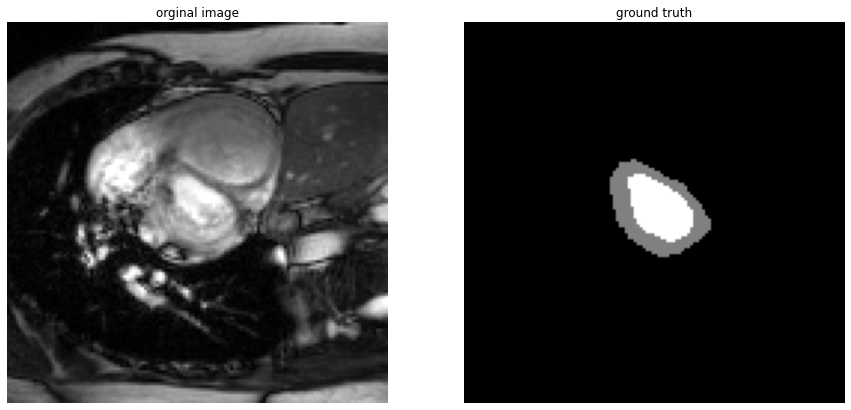

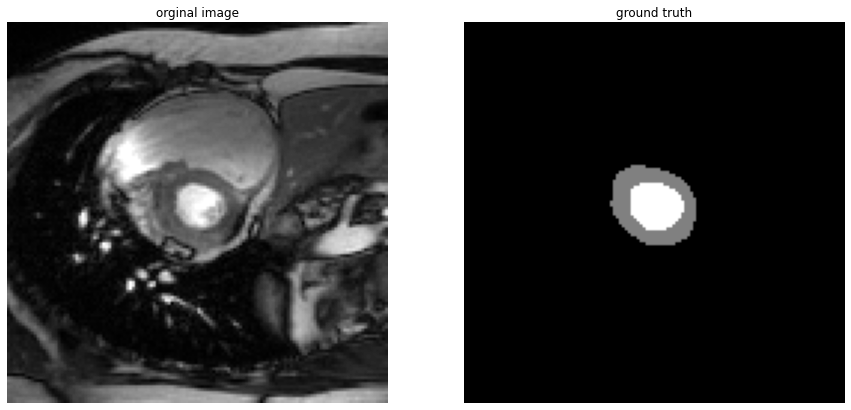

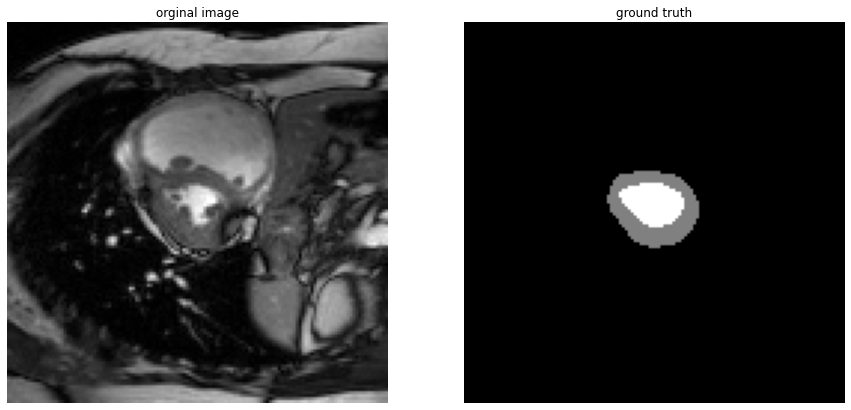

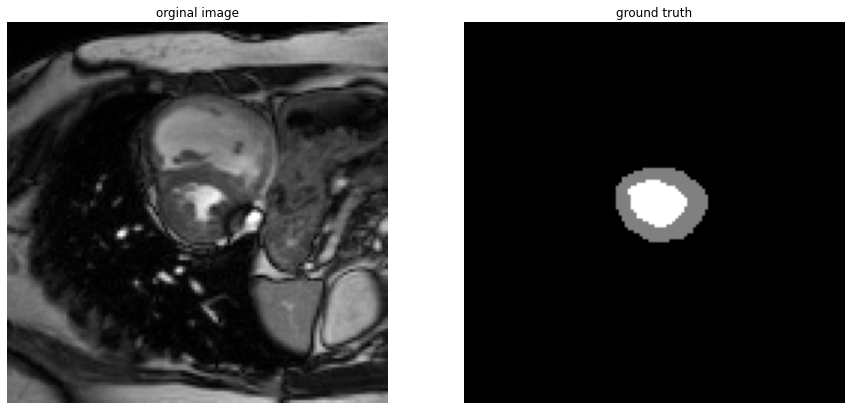

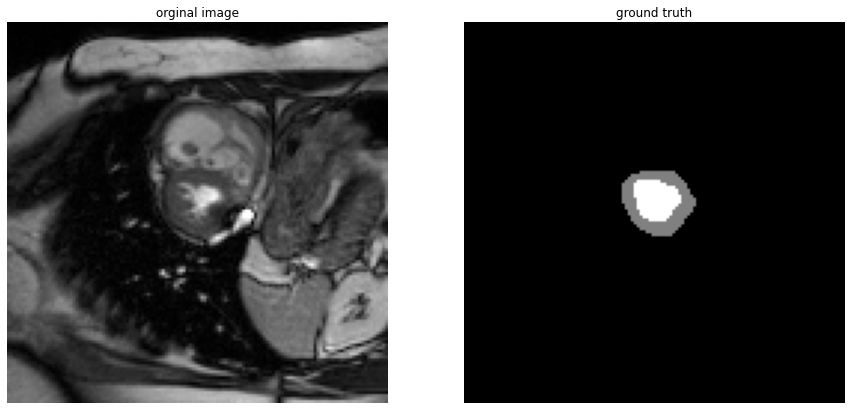

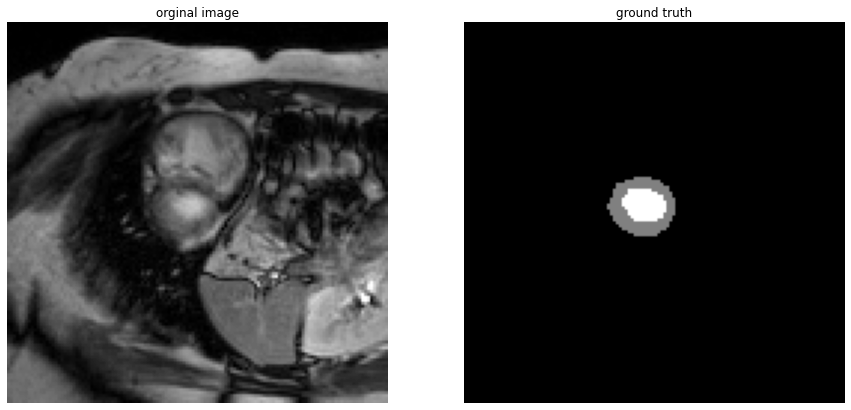

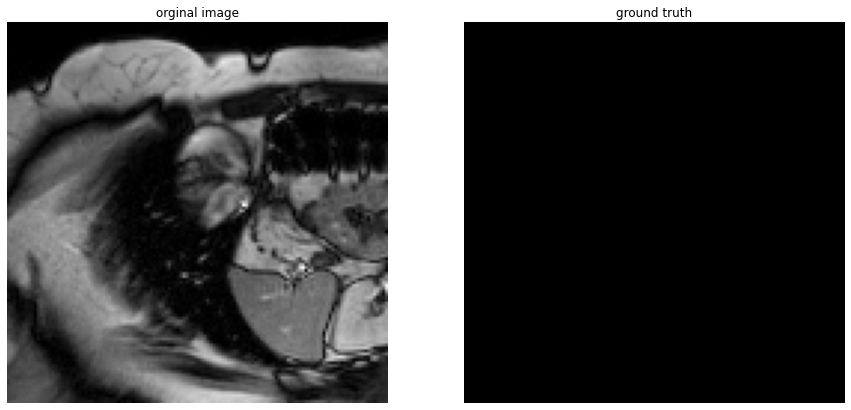

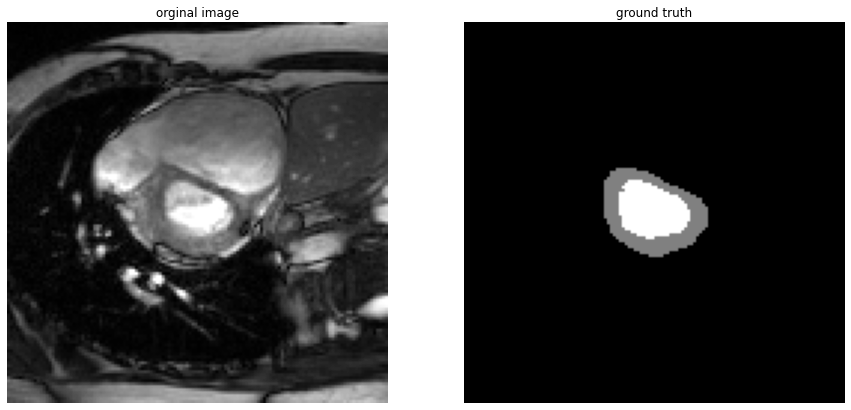

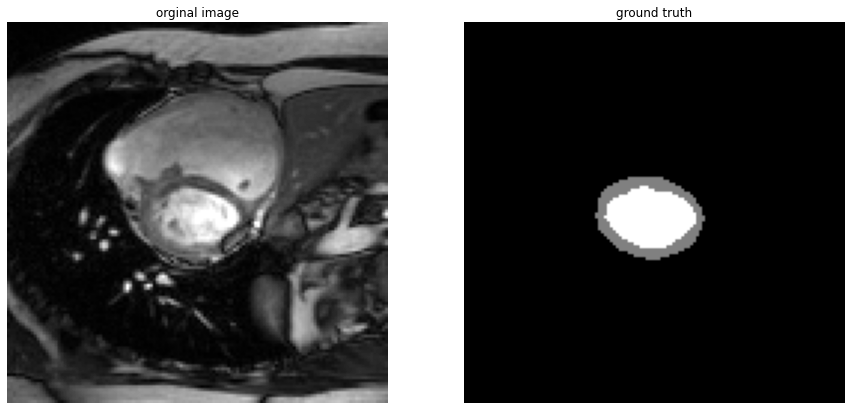

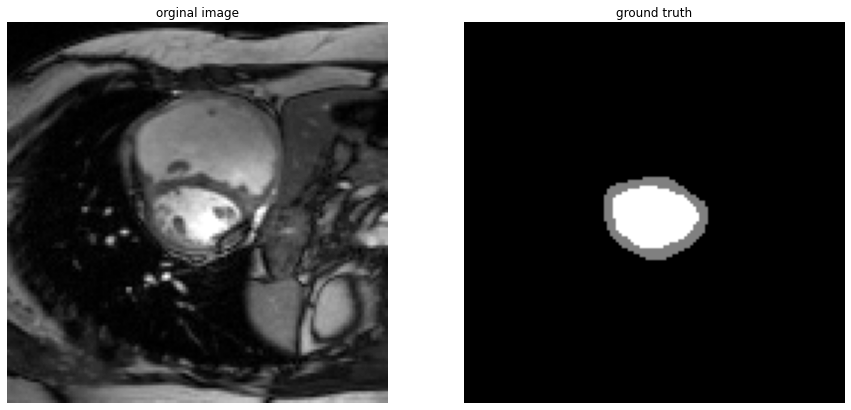

In [ ]:
for i in range(10):
    plt.figure(i,figsize=(15,15))
    plt.subplot(121), plt.imshow(np.squeeze(x[i]),cmap='gray'),plt.axis('off') , plt.title('orginal image')
    plt.subplot(122), plt.imshow(np.squeeze(y[i]),cmap='gray'),plt.axis('off') , plt.title('ground truth')

In [ ]:
def visualize(im,la,pred):
  for i in range(10):
    plt.figure(i,figsize=(15,15))
    plt.subplot(131), plt.imshow(np.squeeze(im[i]),cmap='gray'),plt.axis('off') , plt.title('orginal image')
    plt.subplot(132), plt.imshow(np.squeeze(la[i]),cmap='gray'),plt.axis('off') , plt.title('ground truth')
    plt.subplot(133), plt.imshow(np.squeeze(pred[i]),cmap='gray'),plt.axis('off') ,plt.title('prediction')

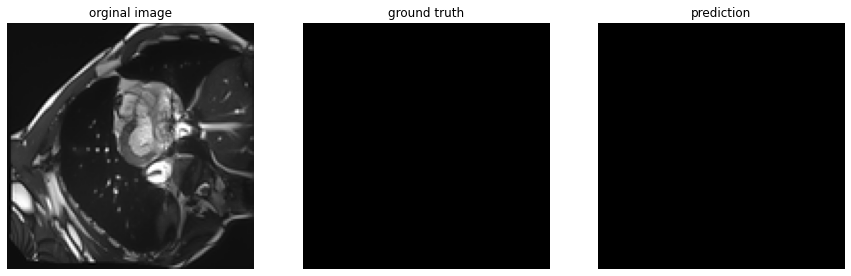

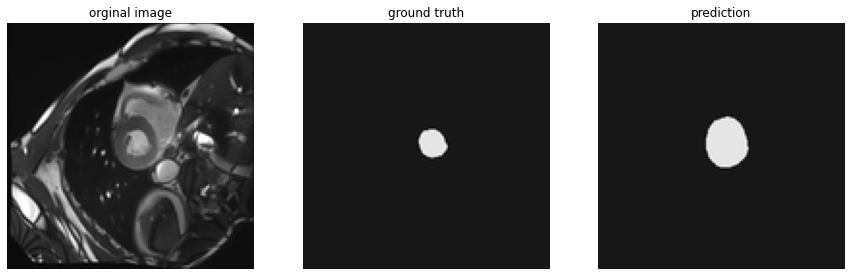

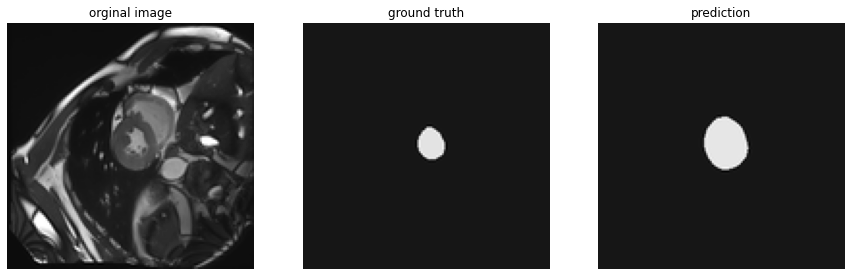

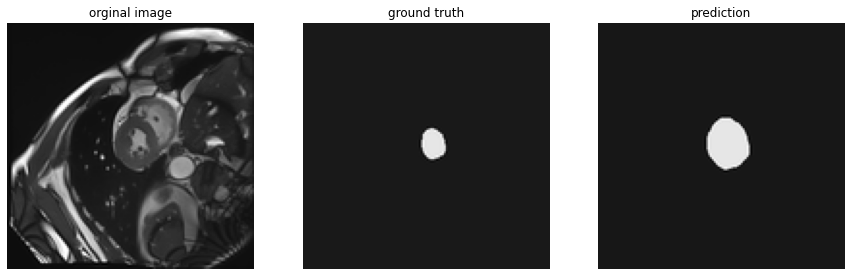

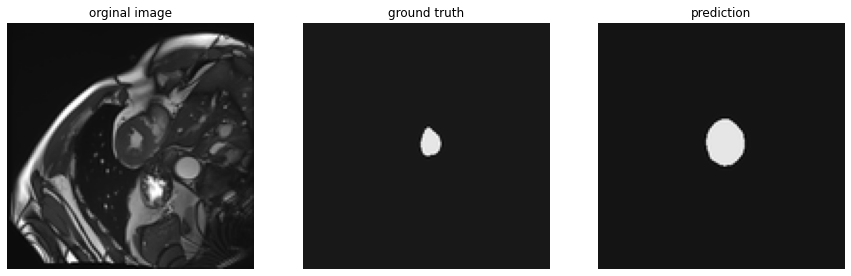

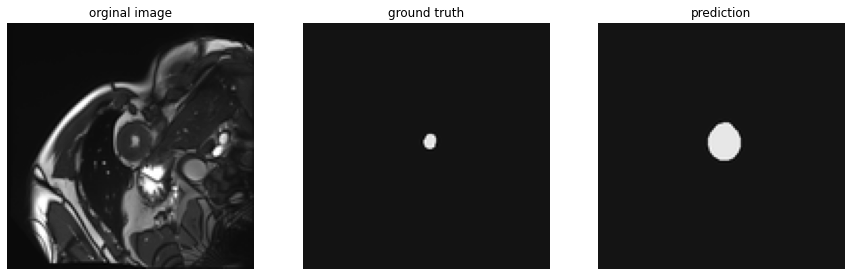

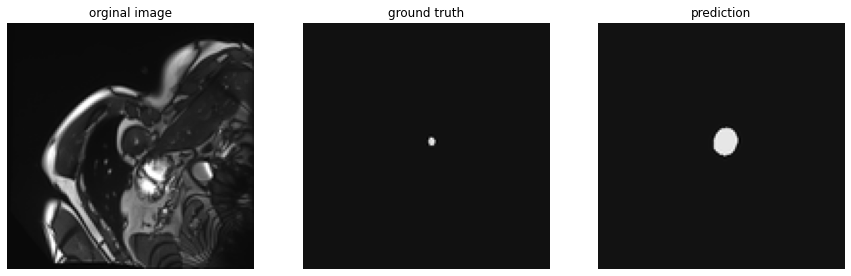

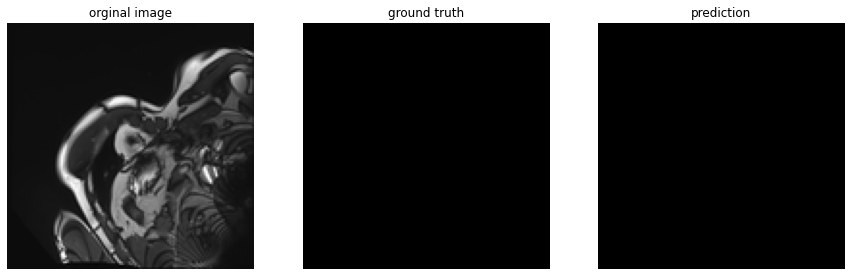

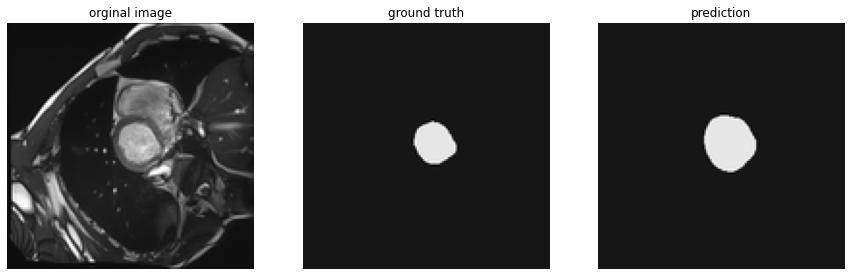

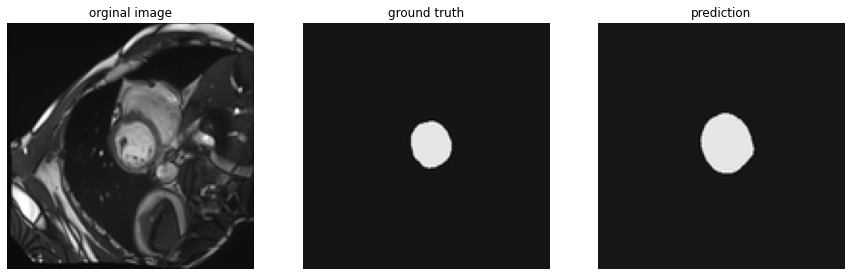

In [ ]:
visualize(x_endo,y_endo,y_epi)